# Hybrid QACGAN with VQE Regularization (5 Epochs Exploratory Run)

**Author:** David Strnadel  
**Date:** December 2025             
**Affiliation:** Faculty of Applied Informatics, Tomas Bata University in Zlin

## Abstract

This notebook implements a hybrid **Quantum-enhanced Auxiliary Classifier GAN (QACGAN)** that augments the classical ACGAN generator objective with a **Variational Quantum Eigensolver (VQE)**-based energy regularization term. The energy is computed from class-specific Ising Hamiltonians using Qiskit's `EstimatorQNN` and `TorchConnector`, enabling gradient backpropagation through the quantum circuit.

**Key Results (5 Epochs):**
- **FID**: **19.92** (vs. ACGAN baseline: 24.02 at epoch 20)
- **Inception Score**: **2.07**
- **Classification Accuracy**: **99%**
- **Training Time**: ~7h 17min (noiseless statevector simulation)

This exploratory run demonstrates that VQE-based regularization can accelerate convergence and improve class consistency within significantly fewer epochs compared to the classical baseline. However, the computational overhead of quantum simulation remains substantial (~1.45 h/epoch).

> **Note:** This is an exploratory proof-of-concept. Results are obtained on a noiseless simulator and should not be interpreted as evidence of quantum advantage.

## 1. Reproducible Environment

This notebook is designed to run on **Google Colab** with GPU acceleration. Execute the cells below to install all required dependencies:

- **Qiskit** and **Qiskit Machine Learning**: Quantum computing framework for VQE simulation
- **PyTorch** and **torchvision**: Deep learning framework for GAN implementation
- **torch-fidelity**: Library for computing FID and Inception Score metrics

> **Note:** The quantum simulation runs on a noiseless `StatevectorEstimator` backend. No real quantum hardware is used.

In [ ]:
#@title Installation of Required Libraries

!pip install --upgrade pip -q
!pip install \
    qiskit \
    qiskit-aer \
    torch \
    torch-fidelity \
    scikit-image \
    ipywidgets \
    pylatexenc \
    -q

!pip install \
  git+https://github.com/qiskit-community/qiskit-machine-learning.git@main#egg=qiskit-machine-learning \
  -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.8 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 164.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 163.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 153.1 MB/s eta 0:00:00
   ━━━━━━━━━━

## 2. Theoretical Foundations

### Generative Adversarial Networks (GANs)
GANs consist of two neural networks—a Generator $G$ and a Discriminator $D$—trained in an adversarial minimax game. Training can suffer from instability and mode collapse.

### Auxiliary Classifier GAN (ACGAN)
ACGAN extends GANs by having the discriminator predict both image authenticity (real/fake) and class labels. The generator $G(z, c)$ produces class-conditional images, leading to more stable training and improved sample quality.

### Variational Quantum Eigensolver (VQE)
VQE is a hybrid quantum-classical algorithm that minimizes the expectation value of a Hamiltonian $\mathcal{H}$ using a parameterized quantum circuit (ansatz) and classical optimization:
$$E(\vec{\theta}) = \langle \psi(\vec{\theta}) | \mathcal{H} | \psi(\vec{\theta}) \rangle$$

### Ising Hamiltonian for Class-Specific Regularization
In QACGAN, each class $c$ is associated with an Ising Hamiltonian:
$$H_c = -J \sum_{\langle i,j \rangle} \sigma_z^i \sigma_z^j - \sum_{i=1}^{N} h_{c,i} \sigma_z^i$$

The VQE energy $E_c$ acts as a physics-inspired regularization term in the generator objective, penalizing configurations misaligned with the target class.

In [ ]:
#@title Verification of Required Libraries Installation

import torch, qiskit, qiskit_machine_learning, torch_fidelity

"""
<summary>
This script prints the versions of the main libraries (PyTorch, Qiskit, Qiskit Machine Learning, Torch-Fidelity)
and verifies the availability of key modules for quantum-classical machine learning.
</summary>
"""

print("PyTorch version:      ", torch.__version__)
print("Qiskit version:       ", qiskit.__version__)
print("Qiskit-ML version:    ", qiskit_machine_learning.__version__)
print("Torch-Fidelity ver.:  ", torch_fidelity.__version__)

from qiskit.primitives import StatevectorEstimator
from qiskit_aer import AerSimulator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

print("✅ All key modules imported successfully!")

PyTorch version:        2.6.0+cu124
Qiskit version:         1.4.3
Qiskit-ML version:      0.9.0
Torch-Fidelity version: 0.3.0
✅ All key modules imported successfully!


In [ ]:
#@title 1. Imports
"""
<summary>
Installation and import of required libraries for PyTorch, Qiskit, and other utilities used in the project.
</summary>
<remarks>
This script contains imports for working with neural networks in PyTorch, image processing with torchvision and skimage,
evaluation with torch-fidelity, and quantum libraries Qiskit including Qiskit Machine Learning.
It also includes multiprocessing setup and version printing of key libraries.
</remarks>
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time
import shutil
import tempfile
from skimage.transform import resize

from torch_fidelity import calculate_metrics

from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit_aer import AerSimulator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

from IPython.display import clear_output
import datetime
from google.colab import files

try:
    torch.multiprocessing.set_start_method('spawn', force=True)
    print("Multiprocessing start method set to 'spawn'.")
except RuntimeError:
    print("Multiprocessing start method was already set.")

print(f"PyTorch version: {torch.__version__}")
import qiskit
print(f"Qiskit version: {qiskit.__version__}")
import qiskit_machine_learning
print(f"Qiskit Machine Learning version: {qiskit_machine_learning.__version__}")

Multiprocessing start method set to 'spawn'.
PyTorch version: 2.6.0+cu124
Qiskit version: 1.4.3
Qiskit Machine Learning version: 0.9.0


In [ ]:
#@title 2. Device, Paths and Configuration Setup
"""
<summary>
Device setup (CPU/GPU), path configuration and check of required files in Google Colab environment for training and evaluation of the model.
</summary>
<remarks>
The script automatically detects GPU availability, sets the appropriate memory format, defines working and output paths, creates required directories, and verifies the presence of the MNIST classifier.
</remarks>
"""

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    MEMORY_FORMAT = torch.channels_last
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU.")
    MEMORY_FORMAT = torch.contiguous_format
print(f"Device in use: {device}, Preferred memory format for models: {MEMORY_FORMAT}")

WORK_DIR = "/content/"
MNIST_DOWNLOAD_PATH = os.path.join(WORK_DIR, "MNIST_data")
MNIST_TRAIN_IMAGES_PATH = os.path.join(MNIST_DOWNLOAD_PATH, "MNIST_train_images_png")
OUTPUT_DIR_IMAGES = os.path.join(WORK_DIR, "hybrid_acgan_images_output")
OUTPUT_DIR_MODELS = os.path.join(WORK_DIR, "hybrid_acgan_models_output")
LOG_FILE = os.path.join(WORK_DIR, "hybrid_acgan_training_logs.pkl")
CLASSIFIER_PATH = os.path.join(WORK_DIR, "mnist_classifier.pth")

os.makedirs(MNIST_DOWNLOAD_PATH, exist_ok=True)
os.makedirs(OUTPUT_DIR_IMAGES, exist_ok=True)
os.makedirs(OUTPUT_DIR_MODELS, exist_ok=True)
print(f"Working directory: {WORK_DIR}")
print(f"Path for MNIST PNG (FID): {MNIST_TRAIN_IMAGES_PATH}")

if not os.path.exists(CLASSIFIER_PATH):
    print(f"\n!!! WARNING: Classifier file '{CLASSIFIER_PATH}' not found! !!!")
    print("Please upload 'mnist_classifier.pth' into Colab (e.g., drag & drop into Files).")
    print("Without it, classification accuracy of generated images cannot be computed.")
else:
    print(f"\nClassifier file '{CLASSIFIER_PATH}' found.")

GPU is available: NVIDIA A100-SXM4-40GB
Device in use: cuda, Preferred memory format for models: torch.channels_last
Working directory: /content/
Path for MNIST PNG (FID): /content/MNIST_data/MNIST_train_images_png

Classifier file '/content/mnist_classifier.pth' found.


In [ ]:
#@title 3. Hyperparameters and Training Configuration
"""
<summary>
Setup of hyperparameters and training configuration for the hybrid quantum-classical model, including model parameters, quantum settings, training hyperparameters, logging and evaluation configuration, and seed initialization for reproducibility.
</summary>
"""

SEED = 42
Z_DIM = 100
NUM_CLASSES = 10
IMG_CHANNELS = 1
IMG_SIZE = 28

N_QUBITS = 4
ANSAETZ_REPS = 1
LAMBDA_VQER = 0.1
ISING_J = 1.0
ISING_H_GLOBAL = 0.1

NUM_EPOCHS = 5
EFFECTIVE_BATCH_SIZE = 64
MICRO_BATCH_SIZE = 32
ACCUMULATION_STEPS = EFFECTIVE_BATCH_SIZE // MICRO_BATCH_SIZE

LEARNING_RATE_G = 0.0002
LEARNING_RATE_D = 0.0002
BETA1 = 0.5
BETA2 = 0.999
LABEL_SMOOTHING = 0.9

LOG_INTERVAL = 50
EVAL_INTERVAL = 5
SAVE_SAMPLES_INTERVAL = 1

NUM_SAMPLES_FOR_METRICS = 1000
NUM_SAMPLES_FOR_ACCURACY = 500

FIDELITY_BATCH_SIZE = MICRO_BATCH_SIZE
FIDELITY_NUM_WORKERS = 2

USE_AMP = False

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

print(f"Hyperparameters set. Effective batch size: {EFFECTIVE_BATCH_SIZE}")
print(f"Number of qubits for quantum part: {N_QUBITS}")
print(f"Lambda for VQE regularization: {LAMBDA_VQER}")

Hyperparameters set. Effective batch size: 64
Number of qubits for quantum part: 4
Lambda for VQE regularization: 0.1


## 4. Quantum Components

This section defines the quantum building blocks for VQE-based regularization:

- **`build_ising_hamiltonian_op`** — Constructs a `SparsePauliOp` representation of the Ising Hamiltonian $H_c$ from the number of qubits, coupling coefficient $J$, and class-specific local fields $h_{c,i}$.

- **EfficientSU2 Ansatz** — A hardware-efficient parameterized quantum circuit with circular entanglement, used to prepare quantum states $|\psi(\vec{\theta})\rangle$.

- **StatevectorEstimator** — Qiskit's noiseless statevector simulator for computing expectation values $\langle H_c \rangle$.

In [ ]:
#@title 4. Definition of Quantum Components
"""
<summary>
Definition of quantum components for the hybrid model:
- Creation of EfficientSU2 ansatz, calculation of the number of ansatz parameters
- Construction of Ising Hamiltonians for each class using SparsePauliOp
- Initialization of StatevectorEstimator for energy computations of quantum states
</summary>
"""

ansatz = EfficientSU2(num_qubits=N_QUBITS, reps=ANSAETZ_REPS, entanglement='circular', insert_barriers=True)
NUM_ANSATZ_PARAMS = ansatz.num_parameters
print(f"Quantum Ansatz: EfficientSU2 with {N_QUBITS} qubits and {ANSAETZ_REPS} reps.")
print(f"Number of ansatz parameters: {NUM_ANSATZ_PARAMS}")

def build_ising_hamiltonian_op(n_qubits, J_coeff=1.0, h_coeffs_list=None):
    """
    <summary>
    Creates an Ising Hamiltonian as SparsePauliOp.
    </summary>
    <param name="n_qubits">Number of qubits in the system.</param>
    <param name="J_coeff">Coefficient of ZZ interaction term.</param>
    <param name="h_coeffs_list">List of external field Z coefficients for each qubit.</param>
    <returns>SparsePauliOp representing the Ising Hamiltonian.</returns>
    """
    if h_coeffs_list is None:
        h_coeffs_list = [ISING_H_GLOBAL] * n_qubits
    if len(h_coeffs_list) != n_qubits:
        raise ValueError("Length of h_coeffs_list must equal n_qubits.")

    pauli_terms = []
    coeffs = []

    for i in range(n_qubits - 1):
        pauli_str = ['I'] * n_qubits
        pauli_str[i] = 'Z'
        pauli_str[i+1] = 'Z'
        pauli_terms.append("".join(pauli_str))
        coeffs.append(-J_coeff)

    for i in range(n_qubits):
        pauli_str = ['I'] * n_qubits
        pauli_str[i] = 'Z'
        pauli_terms.append("".join(pauli_str))
        coeffs.append(-h_coeffs_list[i])

    return SparsePauliOp(pauli_terms, coeffs=coeffs)

H_op_list = []
for i in range(NUM_CLASSES):
    h_coeffs_class = [ISING_H_GLOBAL + (i * 0.01) for _ in range(N_QUBITS)]
    H_op_list.append(build_ising_hamiltonian_op(N_QUBITS, J_coeff=ISING_J, h_coeffs_list=h_coeffs_class))

print(f"Created {len(H_op_list)} Hamiltonians (one per class).")
print(f"Example Hamiltonian for class 0: {H_op_list[0].paulis}")

aer_estimator = StatevectorEstimator()
print("StatevectorEstimator initialized.")

Quantum Ansatz: EfficientSU2 with 4 qubits and 1 reps.
Number of ansatz parameters: 16
Created 10 Hamiltonians (one per class).
Example Hamiltonian for class 0: ['ZZII', 'IZZI', 'IIZZ', 'ZIII', 'IZII', 'IIZI', 'IIIZ']
StatevectorEstimator initialized.


## 5. Model Architecture

### HybridGenerator
The generator consists of two parallel branches:

1. **Classical Branch**: Transposed convolutions producing 28×28 pixel images from latent vector $z$ and class embedding $c$.

2. **VQE Energy Branch** (active when $\lambda_{\text{VQE}} > 0$):
   - `AngleProducer` MLP maps $(z, c)$ to circuit parameters $\vec{\theta}$
   - **EfficientSU2** ansatz prepares quantum state $|\psi(\vec{\theta})\rangle$
   - **EstimatorQNN** computes energy $E_c = \langle \psi | H_c | \psi \rangle$

The `forward` method returns the tuple *(generated_image, $E_c$)*.

### Discriminator
- Convolutional backbone ending in 4×4 feature maps
- Flattened features feed into two heads:
  - **adv_layer**: Real/fake probability (Sigmoid output)
  - **aux_layer**: Class logits (10 outputs for MNIST digits)

This architecture follows DCGAN design principles with strided convolutions and batch normalization.

In [ ]:
#@title 5. Definition of Models (Discriminator, Classifier, Hybrid Generator)
# --- 5.1 Classical MNIST Classifier (for evaluation) ---
class MnistClassifier(nn.Module):
    """
    <summary>
    Classical convolutional neural network classifier for the MNIST dataset.
    </summary>
    <param name="num_classes">Number of classes for classification (default 10).</param>
    <returns>Logits for each class.</returns>
    """
    def __init__(self, num_classes=10):
        super(MnistClassifier, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.flatten_size = 64 * 7 * 7
        self.fc_block = nn.Sequential(
            nn.Linear(self.flatten_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes))
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.reshape(x.size(0), -1)
        logits = self.fc_block(x)
        return logits

# --- 5.2 Classical ACGAN Discriminator ---
class Discriminator(nn.Module):
    """
    <summary>
    Discriminator for the ACGAN architecture with recognition of both class and image authenticity.
    </summary>
    <param name="num_classes">Number of classes for the classification output.</param>
    <param name="img_channels">Number of channels of input images.</param>
    <returns>
        validity: Image authenticity score.
        class_logits: Logits for class prediction.
    </returns>
    """
    def __init__(self, num_classes=NUM_CLASSES, img_channels=IMG_CHANNELS):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.img_channels = img_channels

        self.main_conv = nn.Sequential(
            nn.Conv2d(self.img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.adv_layer = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )
        self.aux_layer = nn.Sequential(
            nn.Linear(256 * 4 * 4, self.num_classes)
        )

    def forward(self, img):
        features = self.main_conv(img)
        flat_features = features.contiguous().view(features.size(0), -1)
        validity = self.adv_layer(flat_features)
        class_logits = self.aux_layer(flat_features)
        return validity, class_logits

# --- 5.3 Component for generating angles for the quantum ansatz ---
class AngleProducer(nn.Module):
    """
    <summary>
    Module producing angles for the parameterized quantum ansatz based on input noise and a conditional label.
    </summary>
    <param name="z_dim">Dimension of the latent vector.</param>
    <param name="num_classes">Number of classes for embedding.</param>
    <param name="num_ansatz_params">Number of parameters of the quantum ansatz.</param>
    <returns>Tensor of angles for the quantum ansatz in the range [-π, π].</returns>
    """
    def __init__(self, z_dim, num_classes, num_ansatz_params):
        super(AngleProducer, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, z_dim)
        self.fc_net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_ansatz_params),
            nn.Tanh()
        )
        self.num_ansatz_params = num_ansatz_params

    def forward(self, z, class_labels):
        embedded_labels = self.label_embedding(class_labels)
        conditioned_z = z * embedded_labels
        angles = self.fc_net(conditioned_z)
        return angles * torch.pi

# --- 5.4 Hybrid Generator (ACGAN + VQE regularization) ---
class HybridGenerator(nn.Module):
    """
    <summary>
    Hybrid generator combining the classical ACGAN architecture and quantum VQE regularization via an ansatz and Ising Hamiltonians.
    </summary>
    <param name="z_dim">Dimension of the input latent vector.</param>
    <param name="num_classes">Number of classes for conditional generation.</param>
    <param name="img_channels">Number of channels of the output image.</param>
    <param name="ansatz_instance">Instance of the parameterized quantum ansatz.</param>
    <param name="list_of_hamiltonians">List of SparsePauliOp Hamiltonians (one per class).</param>
    <param name="qiskit_estimator">Instance of Qiskit estimator for energy computations.</param>
    <param name="lambda_vqer_coeff">Weight of the VQE regularization term in the loss function.</param>
    <returns>
        img_classic: Generated image.
        E_c_batch: Energy for each sample in the batch.
    </returns>
    """
    def __init__(self, z_dim, num_classes, img_channels,
                 ansatz_instance,
                 list_of_hamiltonians,
                 qiskit_estimator,
                 lambda_vqer_coeff):
        super(HybridGenerator, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.img_channels = img_channels
        self.ansatz = ansatz_instance
        self.num_ansatz_params = ansatz_instance.num_parameters
        self.lambda_vqer = lambda_vqer_coeff

        self.classic_label_embedding = nn.Embedding(self.num_classes, self.num_classes)
        self.classic_input_layer = nn.Linear(self.z_dim + self.num_classes, 256 * 7 * 7)
        self.classic_main_generator_cnn = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, self.img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        self.angle_producer = AngleProducer(self.z_dim, self.num_classes, self.num_ansatz_params)

        self.qnn_module_list = nn.ModuleList()
        for h_op in list_of_hamiltonians:
            qnn_c = EstimatorQNN(
                circuit=self.ansatz,
                observables=h_op,
                input_params=list(self.ansatz.parameters),
                input_gradients=True,
                estimator=qiskit_estimator
            )
            self.qnn_module_list.append(TorchConnector(qnn_c, initial_weights=None))

    def forward(self, z, class_labels):
        classic_embedded_lbls = self.classic_label_embedding(class_labels)
        classic_gen_in = torch.cat((z, classic_embedded_lbls), 1)
        classic_img_features_flat = self.classic_input_layer(classic_gen_in)
        classic_img_features_map = classic_img_features_flat.view(classic_img_features_flat.size(0), 256, 7, 7)
        img_classic = self.classic_main_generator_cnn(classic_img_features_map)

        angles_for_qnn = self.angle_producer(z, class_labels)

        batch_size = z.size(0)
        energies_for_batch = []
        for i in range(batch_size):
            label_index = class_labels[i].item()
            qnn_for_this_class = self.qnn_module_list[label_index]
            current_sample_angles = angles_for_qnn[i].unsqueeze(0)
            energy_tensor = qnn_for_this_class(current_sample_angles)
            energies_for_batch.append(energy_tensor.squeeze())

        E_c_batch = torch.stack(energies_for_batch)
        return img_classic, E_c_batch

# --- Weight initialization ---
def weights_init(m):
    """
    <summary>
    Initializes model weights depending on the layer type.
    </summary>
    <param name="m">Model layer.</param>
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

print("Model definitions and weight initialization completed.")


Model definitions and weight initialization completed.


## 6. Data Preparation

This section handles MNIST dataset loading and preprocessing:

1. **Download MNIST** — 60,000 training images of handwritten digits (28×28 grayscale)
2. **Normalization** — Images normalized to range $[-1, 1]$ to match generator's Tanh output
3. **PNG Export** — Training images saved as individual PNGs for `torch-fidelity` FID/IS computation
4. **DataLoader** — Micro-batches of 32 images with shuffling enabled

In [ ]:
#@title 6. Příprava datového souboru a pomocné funkce

def save_mnist_as_images(dataset_path_root, output_dir):
    """
    <summary>
    Uloží obrázky z MNIST trénovacího datasetu do PNG souborů v daném adresáři.
    Kontroluje, zda adresář již obsahuje dostatečný počet obrázků, případně je generuje znovu.
    </summary>
    <param name="dataset_path_root">Cesta ke kořenové složce datasetu MNIST.</param>
    <param name="output_dir">Cílový adresář pro uložení PNG obrázků.</param>
    <returns>True, pokud jsou obrázky úspěšně uloženy nebo již existují, jinak False.</returns>
    """
    num_mnist_train = 60000
    if os.path.exists(output_dir):
        try:
            num_files = len([f for f in os.listdir(output_dir) if f.endswith('.png')])
            if num_files >= num_mnist_train:
                print(f"Adresář '{output_dir}' již existuje a zdá se být kompletní. Přeskakuji generování PNG.")
                return True
            else:
                print(f"Adresář '{output_dir}' existuje, ale je nekompletní. Mažu a generuji znovu.")
                shutil.rmtree(output_dir)
        except OSError as e:
            print(f"Chyba při kontrole adresáře {output_dir}: {e}. Pokračuji s generováním...")

    os.makedirs(output_dir, exist_ok=True)
    print(f"Generuji MNIST trénovací obrázky do '{output_dir}'...")
    transform_save = transforms.Compose([transforms.ToTensor()])
    try:
        mnist_dataset = datasets.MNIST(root=dataset_path_root, train=True, download=True, transform=transform_save)
    except Exception as e:
        print(f"FATAL: Nepodařilo se stáhnout/načíst MNIST dataset z '{dataset_path_root}'. Chyba: {e}")
        return False

    for i, (image, label) in enumerate(mnist_dataset):
        save_image(image, os.path.join(output_dir, f"mnist_train_{i:05d}.png"), normalize=False)
        if (i + 1) % 5000 == 0:
            print(f"  Uloženo {i + 1}/{len(mnist_dataset)} obrázků...")
    print(f"Úspěšně uloženo {len(mnist_dataset)} MNIST PNG obrázků do '{output_dir}'.")
    return True

if not save_mnist_as_images(MNIST_DOWNLOAD_PATH, MNIST_TRAIN_IMAGES_PATH):
    print("Chyba při přípravě MNIST PNG obrázků. Výpočet FID nebude možný.")

transform_train = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

try:
    train_dataset = datasets.MNIST(root=MNIST_DOWNLOAD_PATH, train=True, download=False, transform=transform_train)
    train_loader = DataLoader(train_dataset, batch_size=MICRO_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
    print(f"Tréninkový dataset MNIST načten: {len(train_dataset)} vzorků.")
except Exception as e:
    print(f"Nepodařilo se načíst MNIST dataset, chyba: {e}.")

def save_generated_samples(epoch, generator_model, fixed_z_noise, fixed_class_labels, output_path, num_samples_per_class=5):
    """
    <summary>
    Uloží vzorky generovaných obrázků z generátoru pro danou epochu do souboru PNG v určeném adresáři.
    </summary>
    <param name="epoch">Číslo aktuální epochy.</param>
    <param name="generator_model">Instance generátoru.</param>
    <param name="fixed_z_noise">Pevně daný šumový vektor pro generování.</param>
    <param name="fixed_class_labels">Pevné labely pro generování.</param>
    <param name="output_path">Cesta do adresáře pro uložení obrázku.</param>
    <param name="num_samples_per_class">Počet obrázků na třídu v jedné řadě v PNG.</param>
    """
    generator_model.eval()
    with torch.no_grad():
        gen_imgs_classic, _ = generator_model(fixed_z_noise.to(device), fixed_class_labels.to(device))
        save_image(gen_imgs_classic.data,
                   os.path.join(output_path, f"hybrid_acgan_samples_epoch_{epoch:03d}.png"),
                   nrow=num_samples_per_class, normalize=True)
    generator_model.train()

def evaluate_hybrid_model(epoch, generator_model, ext_classifier,
                          num_metrics_samples, num_accuracy_samples,
                          ref_mnist_png_path, current_device):
    """
    <summary>
    Vyhodnotí hybridní generátor na základě FID, IS a klasifikační přesnosti.
    Generuje vzorky, ukládá je dočasně pro výpočet metrik a případně počítá přesnost pomocí externího klasifikátoru.
    </summary>
    <param name="epoch">Číslo epochy (pro logování).</param>
    <param name="generator_model">Instance generátoru.</param>
    <param name="ext_classifier">Externí klasifikátor pro měření přesnosti (nepovinný).</param>
    <param name="num_metrics_samples">Počet vzorků pro FID/IS.</param>
    <param name="num_accuracy_samples">Počet vzorků pro test přesnosti.</param>
    <param name="ref_mnist_png_path">Cesta k referenčním MNIST PNG obrázkům.</param>
    <param name="current_device">Používané zařízení (CPU/GPU).</param>
    <returns>
        tuple(fid_score, is_score_mean, classification_accuracy)
        fid_score: Hodnota Frechet Inception Distance.
        is_score_mean: Průměrná hodnota Inception Score.
        classification_accuracy: Přesnost klasifikace generovaných obrázků.
    </returns>
    """
    generator_model.eval()
    if ext_classifier: ext_classifier.eval()

    fid_score, is_score_mean, classification_accuracy = float('nan'), float('nan'), float('nan')
    temp_gen_img_dir = tempfile.mkdtemp()

    try:
        print(f"  Generuji {num_metrics_samples} vzorků pro FID/IS do '{temp_gen_img_dir}'...")
        img_counter = 0
        with torch.no_grad():
            num_batches_needed = (num_metrics_samples + MICRO_BATCH_SIZE -1) // MICRO_BATCH_SIZE
            for _ in range(num_batches_needed):
                if img_counter >= num_metrics_samples: break
                batch_z = torch.randn(MICRO_BATCH_SIZE, Z_DIM, device=current_device)
                batch_labels_fid = torch.randint(0, NUM_CLASSES, (MICRO_BATCH_SIZE,), device=current_device)
                gen_imgs_fid_classic, _ = generator_model(batch_z, batch_labels_fid)
                for img_tensor in gen_imgs_fid_classic.detach().cpu():
                    if img_counter >= num_metrics_samples: break
                    save_image(img_tensor,
                               os.path.join(temp_gen_img_dir, f"fid_img_{img_counter:05d}.png"),
                               normalize=True)
                    img_counter +=1

        if img_counter >= num_metrics_samples:
            print(f"  Obrázky ({img_counter}) pro metriky uloženy. Počítám FID/IS pomocí torch-fidelity...")
            metrics_dict = calculate_metrics(
                input1=temp_gen_img_dir,
                input2=ref_mnist_png_path,
                cuda=torch.cuda.is_available(),
                isc=True, fid=True,
                batch_size=FIDELITY_BATCH_SIZE,
                num_workers=FIDELITY_NUM_WORKERS,
                verbose=False
            )
            fid_score = metrics_dict.get('frechet_inception_distance', float('nan'))
            is_score_mean = metrics_dict.get('inception_score_mean', float('nan'))
            print(f"  FID: {fid_score:.4f}, IS (mean): {is_score_mean:.4f}")
        else:
            print(f"  Nedostatek vygenerovaných vzorků ({img_counter}/{num_metrics_samples}) pro FID/IS.")

    except Exception as e:
        print(f"  CHYBA při výpočtu FID/IS: {e}")
    finally:
        if os.path.exists(temp_gen_img_dir):
            shutil.rmtree(temp_gen_img_dir)

    if ext_classifier:
        try:
            print(f"  Generuji {num_accuracy_samples} vzorků pro test klasifikace...")
            all_preds, all_targets = [], []
            num_samples_per_class_acc = num_accuracy_samples // NUM_CLASSES
            with torch.no_grad():
                for digit_class in range(NUM_CLASSES):
                    acc_z = torch.randn(num_samples_per_class_acc, Z_DIM, device=current_device)
                    acc_target_labels = torch.full((num_samples_per_class_acc,), digit_class, dtype=torch.long, device=current_device)
                    gen_imgs_acc_classic, _ = generator_model(acc_z, acc_target_labels)
                    outputs = ext_classifier(gen_imgs_acc_classic)
                    _, predicted = torch.max(outputs.data, 1)
                    all_preds.append(predicted.cpu())
                    all_targets.append(acc_target_labels.cpu())

            if all_preds:
                all_preds_tensor = torch.cat(all_preds)
                all_targets_tensor = torch.cat(all_targets)
                correct_predictions = (all_preds_tensor == all_targets_tensor).sum().item()
                total_for_accuracy = len(all_targets_tensor)
                if total_for_accuracy > 0:
                    classification_accuracy = 100. * correct_predictions / total_for_accuracy
                    print(f"  Přesnost klasifikace generovaných obrázků: {classification_accuracy:.2f}%")
                else:
                    print("  Nebyly generovány žádné vzorky pro výpočet přesnosti.")
            else:
                 print("  Nebyly generovány žádné predikce pro výpočet přesnosti.")

        except Exception as e:
            print(f"  CHYBA při výpočtu přesnosti klasifikace: {e}")
    else:
        print("  Externí klasifikátor není k dispozici, přesnost klasifikace se nepočítá.")

    generator_model.train()
    return fid_score, is_score_mean, classification_accuracy

Generuji MNIST trénovací obrázky do '/content/MNIST_data/MNIST_train_images_png'...


100%|██████████| 9.91M/9.91M [00:10<00:00, 908kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.91MB/s]


  Uloženo 5000/60000 obrázků...
  Uloženo 10000/60000 obrázků...
  Uloženo 15000/60000 obrázků...
  Uloženo 20000/60000 obrázků...
  Uloženo 25000/60000 obrázků...
  Uloženo 30000/60000 obrázků...
  Uloženo 35000/60000 obrázků...
  Uloženo 40000/60000 obrázků...
  Uloženo 45000/60000 obrázků...
  Uloženo 50000/60000 obrázků...
  Uloženo 55000/60000 obrázků...
  Uloženo 60000/60000 obrázků...
Úspěšně uloženo 60000 MNIST PNG obrázků do '/content/MNIST_data/MNIST_train_images_png'.
Tréninkový dataset MNIST načten: 60000 vzorků.


In [ ]:
#@title 7. Inicializace modelů, ztrátových funkcí a optimalizátorů

"""
<summary>
Inicializace modelů (diskriminátor, hybridní generátor, externí MNIST klasifikátor),
ztrátových funkcí, optimalizátorů a proměnných pro logování a vizualizaci v rámci tréninku hybridní kvantově-klasické ACGAN architektury.
</summary>
"""

discriminator = Discriminator(num_classes=NUM_CLASSES, img_channels=IMG_CHANNELS).to(device, memory_format=MEMORY_FORMAT)
discriminator.apply(weights_init)

hybrid_generator = HybridGenerator(
    z_dim=Z_DIM,
    num_classes=NUM_CLASSES,
    img_channels=IMG_CHANNELS,
    ansatz_instance=ansatz,
    list_of_hamiltonians=H_op_list,
    qiskit_estimator=aer_estimator,
    lambda_vqer_coeff=LAMBDA_VQER
).to(device)
hybrid_generator.apply(weights_init)

mnist_classifier_eval = MnistClassifier().to(device)
if os.path.exists(CLASSIFIER_PATH):
    try:
        mnist_classifier_eval.load_state_dict(torch.load(CLASSIFIER_PATH, map_location=device))
        mnist_classifier_eval.eval()
        print(f"Externí MNIST klasifikátor '{CLASSIFIER_PATH}' úspěšně načten.")
    except Exception as e:
        print(f"CHYBA při načítání externího klasifikátoru: {e}. Přesnost se nebude počítat.")
        mnist_classifier_eval = None
else:
    print(f"Externí MNIST klasifikátor '{CLASSIFIER_PATH}' nenalezen. Přesnost se nebude počítat.")
    mnist_classifier_eval = None

adversarial_loss_fn = nn.BCELoss().to(device)
auxiliary_loss_fn = nn.CrossEntropyLoss().to(device)

optimizer_G = optim.Adam(hybrid_generator.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D, betas=(BETA1, BETA2))

num_fixed_samples_display = NUM_CLASSES * 5
fixed_z = torch.randn(num_fixed_samples_display, Z_DIM, device=device)
fixed_labels_list = []
for i in range(NUM_CLASSES):
    fixed_labels_list.extend([i] * 5)
fixed_labels = torch.LongTensor(fixed_labels_list).to(device)

training_logs = {
    'iterations': [], 'epochs': [],
    'g_loss': [], 'g_adv_loss': [], 'g_aux_loss': [], 'g_vqe_loss': [], 'avg_energy': [],
    'd_loss': [], 'd_real_adv_loss': [], 'd_fake_adv_loss': [], 'd_real_aux_loss': [], 'd_fake_aux_loss': [],
    'eval_epochs': [], 'fid_scores': [], 'is_scores': [], 'classification_accuracy': []
}
best_fid = float('inf')
best_epoch = -1

print("Inicializace modelů, ztrát a optimalizátorů dokončena.")

def count_parameters(model):
    """
    <summary>
    Spočítá a vrátí počet trénovatelných parametrů v zadaném modelu.
    </summary>
    <param name="model">PyTorch model.</param>
    <returns>Celkový počet trénovatelných parametrů modelu.</returns>
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Počet trénovatelných parametrů Hybridního Generátoru: {count_parameters(hybrid_generator):,}")
print(f"Počet trénovatelných parametrů Diskriminátoru: {count_parameters(discriminator):,}")
if mnist_classifier_eval:
    print(f"Počet trénovatelných parametrů Eval Klasifikátoru: {count_parameters(mnist_classifier_eval):,}")

Externí MNIST klasifikátor '/content/mnist_classifier.pth' úspěšně načten.
Inicializace modelů, ztrát a optimalizátorů dokončena.
Počet trénovatelných parametrů Hybridního Generátoru: 1,813,853
Počet trénovatelných parametrů Diskriminátoru: 472,843
Počet trénovatelných parametrů Eval Klasifikátoru: 3,274,634


## 8. Training Loop

### Training Hyperparameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| `NUM_EPOCHS` | 5 | Total training epochs |
| `EFFECTIVE_BATCH_SIZE` | 64 | Effective batch size (32 × 2 accumulation) |
| `LEARNING_RATE` | 2 × 10⁻⁴ | Adam learning rate for G and D |
| `BETA1`, `BETA2` | 0.5, 0.999 | Adam momentum parameters |
| `LABEL_SMOOTHING` | 0.9 | Smoothed real labels for discriminator |
| `λ_VQE` | 0.1 | Weight of VQE regularization term |
| `N_QUBITS` | 4 | Number of qubits in quantum circuit |
| `ANSATZ_REPS` | 1 | Repetitions in EfficientSU2 ansatz |
| `ISING_J` | 1.0 | ZZ coupling coefficient |
| `ISING_H_GLOBAL` | 0.1 | Base local field strength |
| `SEED` | 42 | Random seed for reproducibility |

### Generator Loss Function
The total generator loss combines adversarial, auxiliary, and VQE terms:
$$\mathcal{L}_G = \mathcal{L}_{\text{adv}} + \mathcal{L}_{\text{aux}} + \lambda_{\text{VQE}} \cdot E_c$$

where $E_c$ is the class-specific Ising energy computed via VQE.

In [ ]:
#@title 8. Tréninková smyčka Hybridního ACGAN

"""
<summary>
Tréninková smyčka pro hybridní ACGAN model s kvantovou VQE regularizací.
Obsahuje hlavní epochy a minibatch iterace, střídavý trénink diskriminátoru a generátoru s akumulací gradientů, logování ztrát a výstupních metrik, ukládání vzorků a modelů, průběžnou evaluaci FID/is/class accuracy.
</summary>
"""

print("Zahajuji trénink Hybridního ACGANu...")
total_iterations = 0
start_time_total = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    epoch_g_loss_sum, epoch_g_adv_sum, epoch_g_aux_sum, epoch_g_vqe_sum, epoch_e_c_sum = 0,0,0,0,0
    epoch_d_loss_sum, epoch_d_real_adv_sum, epoch_d_fake_adv_sum, epoch_d_real_aux_sum, epoch_d_fake_aux_sum = 0,0,0,0,0

    hybrid_generator.train()
    discriminator.train()

    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

    for i, (real_imgs_batch, real_class_labels_batch) in enumerate(train_loader):
        current_batch_size = real_imgs_batch.size(0)
        real_imgs_batch = real_imgs_batch.to(device, memory_format=MEMORY_FORMAT if device.type == 'cuda' else torch.contiguous_format)
        real_class_labels_batch = real_class_labels_batch.to(device)

        real_targets_adv = torch.full((current_batch_size, 1), LABEL_SMOOTHING, device=device, dtype=torch.float32)
        fake_targets_adv = torch.full((current_batch_size, 1), 0.0, device=device, dtype=torch.float32)

        real_validity_D, real_class_logits_D = discriminator(real_imgs_batch)
        d_real_adv = adversarial_loss_fn(real_validity_D, real_targets_adv)
        d_real_aux = auxiliary_loss_fn(real_class_logits_D, real_class_labels_batch)

        z_noise_D = torch.randn(current_batch_size, Z_DIM, device=device)
        gen_class_labels_D = torch.randint(0, NUM_CLASSES, (current_batch_size,), device=device, dtype=torch.long)
        fake_imgs_classic_D, _ = hybrid_generator(z_noise_D, gen_class_labels_D)
        fake_validity_D, fake_class_logits_D = discriminator(fake_imgs_classic_D.detach())
        d_fake_adv = adversarial_loss_fn(fake_validity_D, fake_targets_adv)
        d_fake_aux = auxiliary_loss_fn(fake_class_logits_D, gen_class_labels_D)

        d_adv_combined = (d_real_adv + d_fake_adv) / 2
        d_aux_combined = (d_real_aux + d_fake_aux) / 2
        d_loss = (d_adv_combined + d_aux_combined) / ACCUMULATION_STEPS

        d_loss.backward()

        epoch_d_loss_sum += d_loss.item() * ACCUMULATION_STEPS
        epoch_d_real_adv_sum += d_real_adv.item()
        epoch_d_fake_adv_sum += d_fake_adv.item()
        epoch_d_real_aux_sum += d_real_aux.item()
        epoch_d_fake_aux_sum += d_fake_aux.item()

        z_noise_G = torch.randn(current_batch_size, Z_DIM, device=device)
        gen_class_labels_G = torch.randint(0, NUM_CLASSES, (current_batch_size,), device=device, dtype=torch.long)
        fake_imgs_classic_G, E_c_G = hybrid_generator(z_noise_G, gen_class_labels_G)
        fake_validity_G, fake_class_logits_G = discriminator(fake_imgs_classic_G)
        g_adv = adversarial_loss_fn(fake_validity_G, real_targets_adv)
        g_aux = auxiliary_loss_fn(fake_class_logits_G, gen_class_labels_G)
        g_vqe_regularizer = hybrid_generator.lambda_vqer * E_c_G.mean()
        g_loss_gan_part = g_adv + g_aux
        g_loss = (g_loss_gan_part + g_vqe_regularizer) / ACCUMULATION_STEPS

        g_loss.backward()

        epoch_g_loss_sum += g_loss.item() * ACCUMULATION_STEPS
        epoch_g_adv_sum += g_adv.item()
        epoch_g_aux_sum += g_aux.item()
        epoch_g_vqe_sum += g_vqe_regularizer.item()
        epoch_e_c_sum += E_c_G.mean().item()

        if (i + 1) % ACCUMULATION_STEPS == 0 or (i + 1) == len(train_loader):
            optimizer_D.step()
            optimizer_D.zero_grad()
            optimizer_G.step()
            optimizer_G.zero_grad()

        total_iterations += 1
        if total_iterations % LOG_INTERVAL == 0:
            print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] [Batch {i+1}/{len(train_loader)}] [Iter {total_iterations}]")
            print(f"  G loss: {g_loss.item()*ACCUMULATION_STEPS:.4f} (Adv: {g_adv.item():.4f}, Aux: {g_aux.item():.4f}, VQE_reg: {g_vqe_regularizer.item():.4f}, E_c: {E_c_G.mean().item():.4f})")
            print(f"  D loss: {d_loss.item()*ACCUMULATION_STEPS:.4f} (RealAdv: {d_real_adv.item():.4f}, FakeAdv: {d_fake_adv.item():.4f}, RealAux: {d_real_aux.item():.4f}, FakeAux: {d_fake_aux.item():.4f})")
            training_logs['iterations'].append(total_iterations)
            training_logs['g_loss'].append(g_loss.item()*ACCUMULATION_STEPS)
            training_logs['g_adv_loss'].append(g_adv.item())
            training_logs['g_aux_loss'].append(g_aux.item())
            training_logs['g_vqe_loss'].append(g_vqe_regularizer.item())
            training_logs['avg_energy'].append(E_c_G.mean().item())
            training_logs['d_loss'].append(d_loss.item()*ACCUMULATION_STEPS)
            training_logs['d_real_adv_loss'].append(d_real_adv.item())
            training_logs['d_fake_adv_loss'].append(d_fake_adv.item())
            training_logs['d_real_aux_loss'].append(d_real_aux.item())
            training_logs['d_fake_aux_loss'].append(d_fake_aux.item())

    epoch_duration = time.time() - epoch_start_time
    num_batches_in_epoch = len(train_loader)
    avg_g_loss = epoch_g_loss_sum / num_batches_in_epoch
    avg_g_adv = epoch_g_adv_sum / num_batches_in_epoch
    avg_g_aux = epoch_g_aux_sum / num_batches_in_epoch
    avg_g_vqe = epoch_g_vqe_sum / num_batches_in_epoch
    avg_E_c = epoch_e_c_sum / num_batches_in_epoch

    avg_d_loss = epoch_d_loss_sum / num_batches_in_epoch
    avg_d_real_adv = epoch_d_real_adv_sum / num_batches_in_epoch
    avg_d_fake_adv = epoch_d_fake_adv_sum / num_batches_in_epoch
    avg_d_real_aux = epoch_d_real_aux_sum / num_batches_in_epoch
    avg_d_fake_aux = epoch_d_fake_aux_sum / num_batches_in_epoch

    print(f"\n--- Konec Epochy {epoch+1}/{NUM_EPOCHS} (Trvání: {epoch_duration:.2f}s) ---")
    print(f"  Avg G Loss: {avg_g_loss:.4f} (Adv: {avg_g_adv:.4f}, Aux: {avg_g_aux:.4f}, VQE_reg: {avg_g_vqe:.4f}, Avg E_c: {avg_E_c:.4f})")
    print(f"  Avg D Loss: {avg_d_loss:.4f} (R_Adv: {avg_d_real_adv:.4f}, F_Adv: {avg_d_fake_adv:.4f}, R_Aux: {avg_d_real_aux:.4f}, F_Aux: {avg_d_fake_aux:.4f})")

    training_logs['epochs'].append(epoch + 1)

    if (epoch + 1) % SAVE_SAMPLES_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
        save_generated_samples(epoch + 1, hybrid_generator, fixed_z, fixed_labels, OUTPUT_DIR_IMAGES)
        print(f"  Vzorky pro epochu {epoch+1} uloženy.")

    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
        print(f"  Provádím evaluaci modelu pro epochu {epoch+1}...")
        fid, is_mean, acc = evaluate_hybrid_model(
            epoch + 1, hybrid_generator, mnist_classifier_eval,
            NUM_SAMPLES_FOR_METRICS, NUM_SAMPLES_FOR_ACCURACY,
            MNIST_TRAIN_IMAGES_PATH, device
        )
        training_logs['eval_epochs'].append(epoch + 1)
        training_logs['fid_scores'].append(fid)
        training_logs['is_scores'].append(is_mean)
        training_logs['classification_accuracy'].append(acc)

        if fid is not None and not np.isnan(fid) and fid < best_fid:
            best_fid = fid
            best_epoch = epoch + 1
            torch.save(hybrid_generator.state_dict(), os.path.join(OUTPUT_DIR_MODELS, 'hybrid_generator_best.pth'))
            torch.save(discriminator.state_dict(), os.path.join(OUTPUT_DIR_MODELS, 'discriminator_best.pth'))
            print(f"  *** Nové nejlepší FID: {best_fid:.4f} v epoše {best_epoch}. Modely uloženy. ***")

    with open(LOG_FILE, 'wb') as f:
        pickle.dump(training_logs, f)
    print("-" * 60)

total_training_time = time.time() - start_time_total
print(f"\nTrénink dokončen za {total_training_time // 3600:.0f}h {(total_training_time % 3600) // 60:.0f}m {total_training_time % 60:.0f}s")
print(f"Nejlepší FID dosaženo: {best_fid:.4f} v epoše {best_epoch}.")

torch.save(hybrid_generator.state_dict(), os.path.join(OUTPUT_DIR_MODELS, 'hybrid_generator_final.pth'))
torch.save(discriminator.state_dict(), os.path.join(OUTPUT_DIR_MODELS, 'discriminator_final.pth'))
print(f"Finální modely uloženy do '{OUTPUT_DIR_MODELS}'.")

Starting training of the Hybrid ACGAN...
[Epoch 1/5] [Batch 50/1875] [Iter 50]
  G loss: 0.3486 (Adv: 0.6156, Aux: 0.0919, VQE_reg: -0.3588, E_c: -3.5882)
  D loss: 1.0817 (RealAdv: 0.3456, FakeAdv: 1.0874, RealAux: 0.6062, FakeAux: 0.1243)
[Epoch 1/5] [Batch 100/1875] [Iter 100]
  G loss: 0.2483 (Adv: 0.5664, Aux: 0.0385, VQE_reg: -0.3566, E_c: -3.5658)
  D loss: 0.9750 (RealAdv: 0.3544, FakeAdv: 1.0377, RealAux: 0.5133, FakeAux: 0.0446)
[Epoch 1/5] [Batch 150/1875] [Iter 150]
  G loss: 0.0935 (Adv: 0.4360, Aux: 0.0173, VQE_reg: -0.3598, E_c: -3.5978)
  D loss: 1.1225 (RealAdv: 0.3338, FakeAdv: 1.4144, RealAux: 0.4649, FakeAux: 0.0318)
[Epoch 1/5] [Batch 200/1875] [Iter 200]
  G loss: 0.8078 (Adv: 1.1550, Aux: 0.0145, VQE_reg: -0.3618, E_c: -3.6177)
  D loss: 0.9117 (RealAdv: 0.7801, FakeAdv: 0.3689, RealAux: 0.6612, FakeAux: 0.0133)
[Epoch 1/5] [Batch 250/1875] [Iter 250]
  G loss: 0.2598 (Adv: 0.5946, Aux: 0.0188, VQE_reg: -0.3537, E_c: -3.5370)
  D loss: 0.8048 (RealAdv: 0.4208, Fa

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 358MB/s]
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


  FID: 19.9179, IS (mean): 2.0743
  Generating 500 samples for the classification test...
  Classification accuracy of generated images: 99.00%
  *** New best FID: 19.9179 at epoch 5. Models saved. ***
------------------------------------------------------------

Training finished in 7h 17m 36s
Best FID achieved: 19.9179 at epoch 5.
Final models saved to '/content/hybrid_acgan_models_output'.


## 9. Evaluation and Visualization

### Results Summary (5 Epochs)

| Metric | QACGAN (5 ep.) | ACGAN Baseline (20 ep.) |
|--------|----------------|-------------------------|
| **FID** ↓ | **19.92** | 24.02 |
| **IS** ↑ | 2.07 | 2.23 |
| **Accuracy** | 99% | 87.8% (at epoch 5) |
| **Training Time** | ~7h 17min | ~27min (50 epochs total) |

### Key Observations
- QACGAN achieves competitive FID in only 5 epochs vs. 20 epochs for ACGAN
- Classification accuracy reaches 99% early, indicating strong class consistency
- The VQE regularization term contributes to faster convergence
- Computational overhead is dominated by quantum simulation (~1.45 h/epoch)

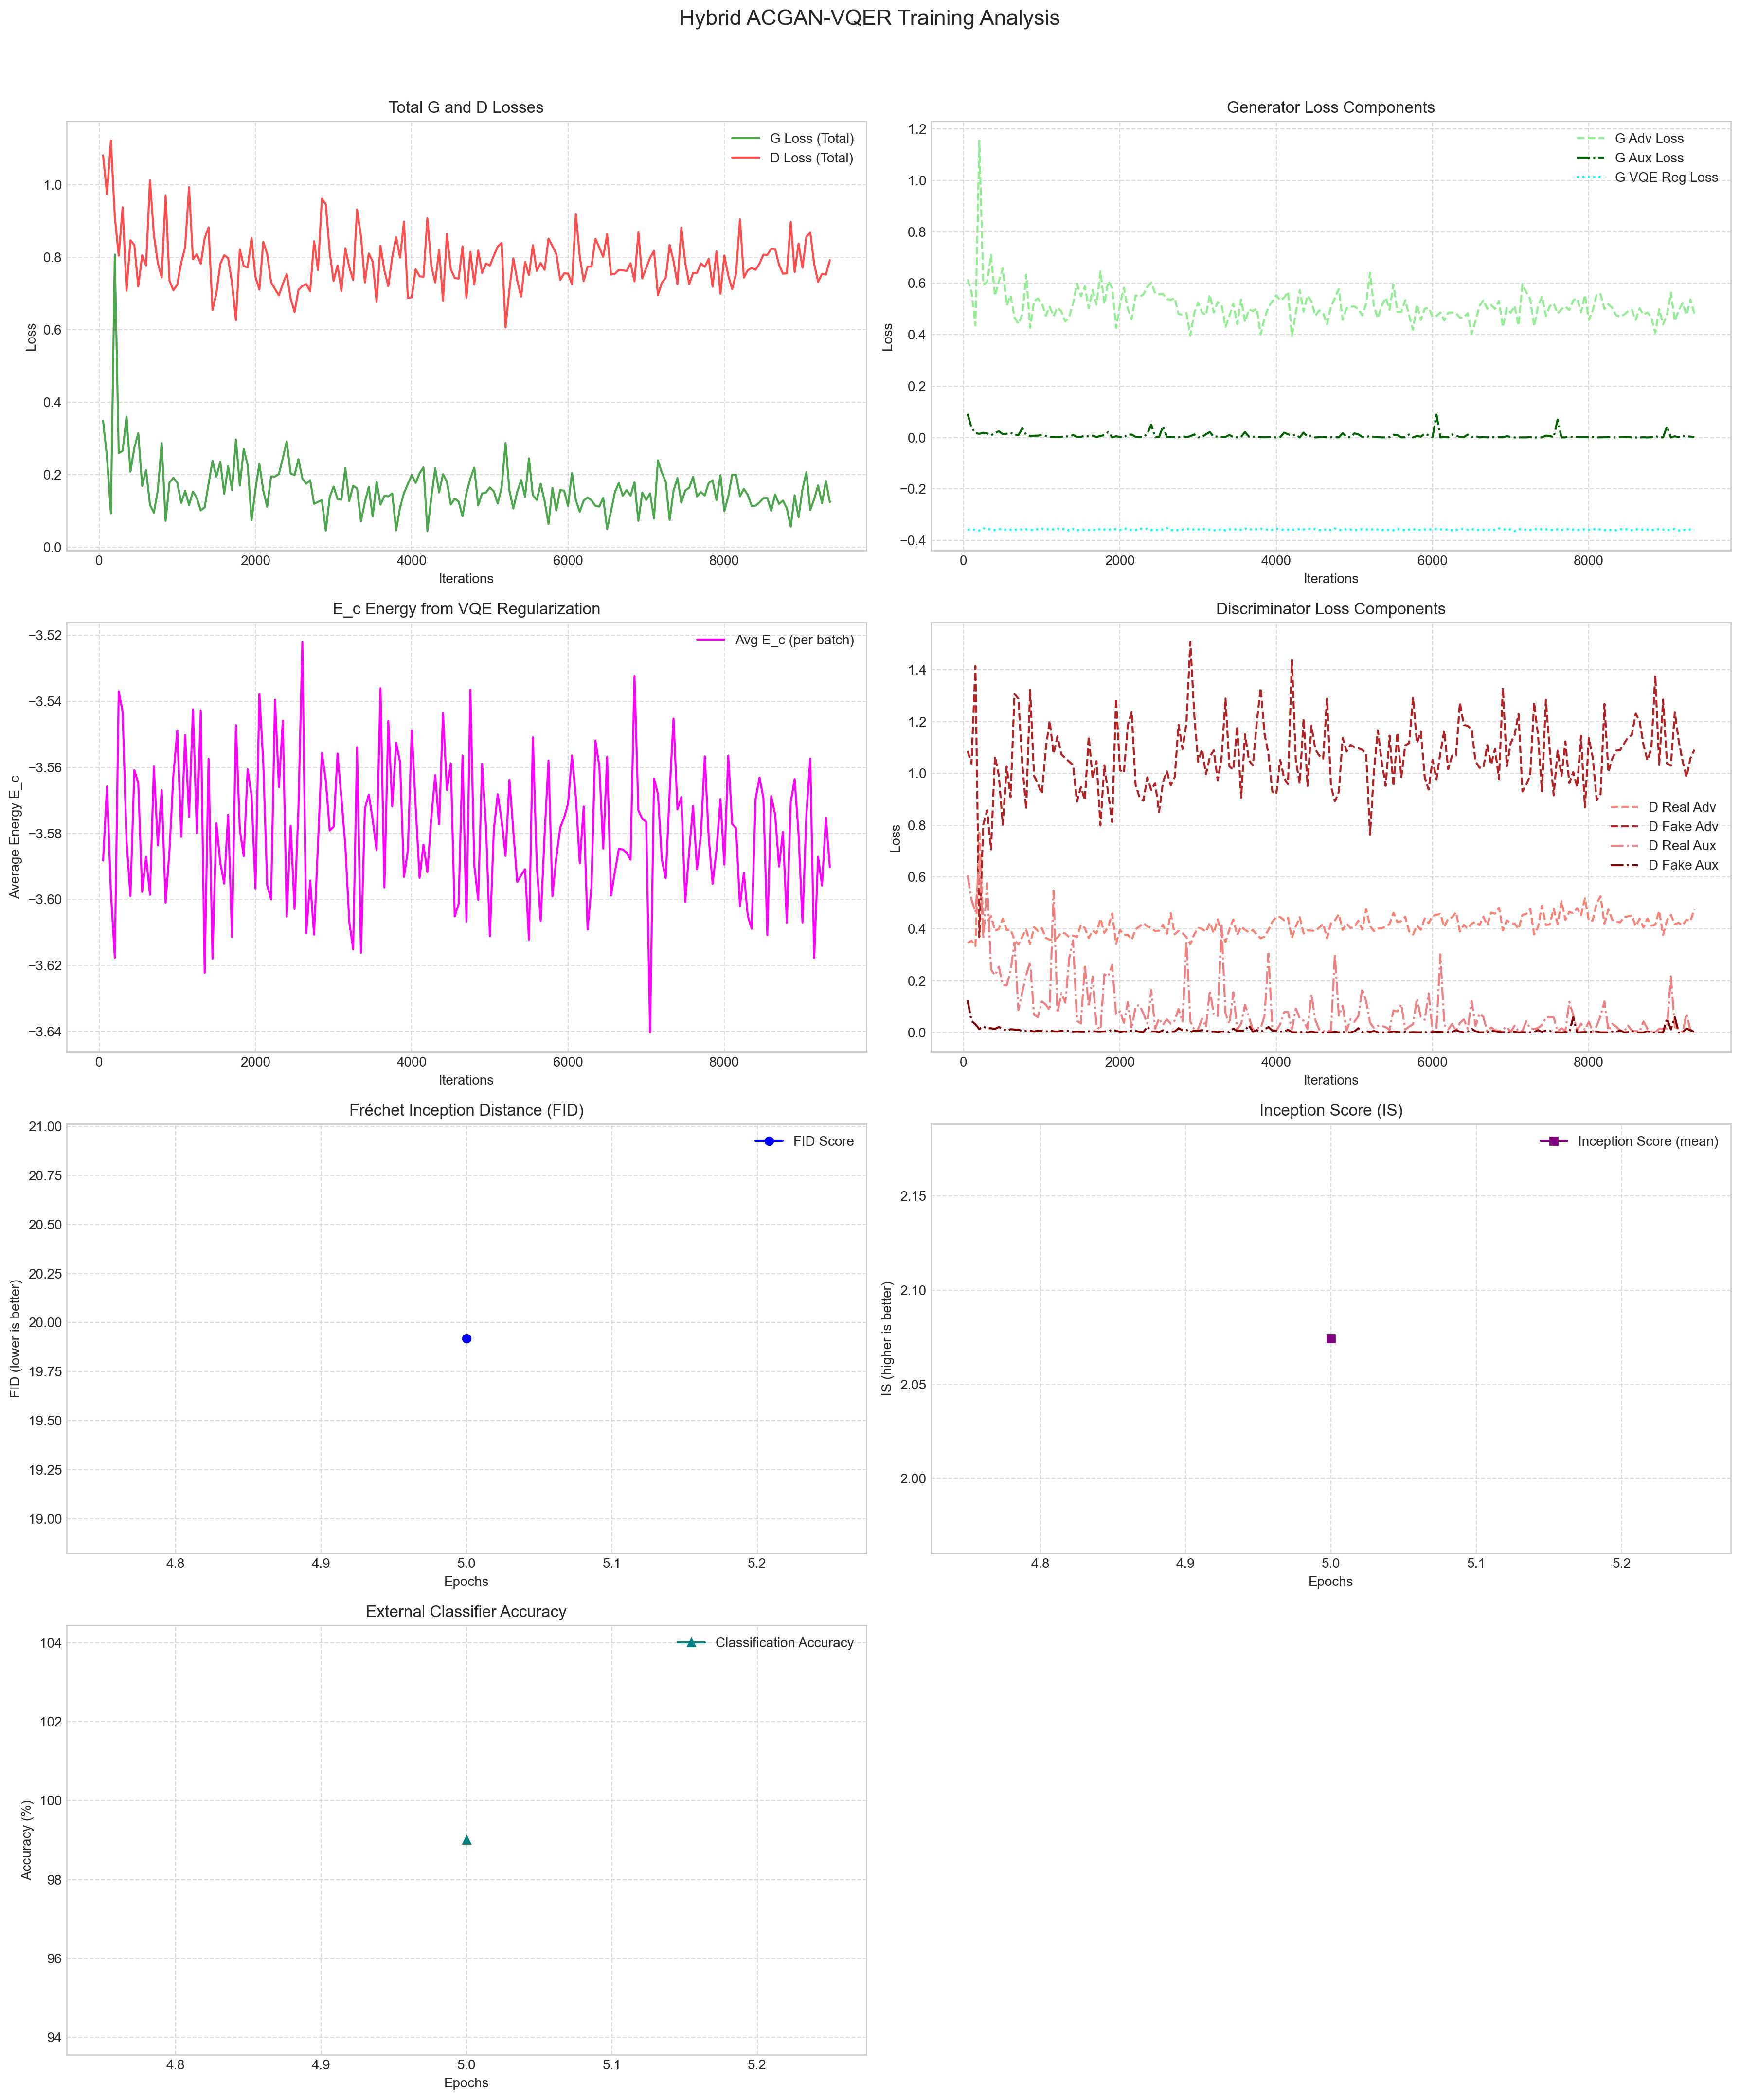

In [ ]:
#@title 9. Visualization of Training Logs

"""
<summary>
Loads the training logs from file and visualizes the training progress of the hybrid ACGAN model.
Plots losses, loss components, energy, FID/IS metrics, and classification accuracy over iterations/epochs.
</summary>
"""

if os.path.exists(LOG_FILE):
    with open(LOG_FILE, 'rb') as f:
        logs = pickle.load(f)

    plt.style.use('seaborn-v0_8-whitegrid')

    fig, axs = plt.subplots(4, 2, figsize=(18, 22))
    fig.suptitle('Hybrid ACGAN-VQER Training Analysis', fontsize=16)

    iters = logs.get('iterations', [])
    epochs_eval = logs.get('eval_epochs', [])

    if iters:
        axs[0, 0].plot(iters, logs.get('g_loss', []), label='G Loss (Total)', color='green', alpha=0.7)
        axs[0, 0].plot(iters, logs.get('d_loss', []), label='D Loss (Total)', color='red', alpha=0.7)
        axs[0, 0].set_xlabel('Iterations')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].set_title('Total G and D Losses')
        axs[0, 0].legend()
        axs[0, 0].grid(True, linestyle='--', alpha=0.7)

    if iters:
        axs[0, 1].plot(iters, logs.get('g_adv_loss', []), label='G Adv Loss', color='lightgreen', linestyle='--')
        axs[0, 1].plot(iters, logs.get('g_aux_loss', []), label='G Aux Loss', color='darkgreen', linestyle='-.')
        axs[0, 1].plot(iters, logs.get('g_vqe_loss', []), label='G VQE Reg Loss', color='cyan', linestyle=':')
        axs[0, 1].set_xlabel('Iterations')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].set_title('Generator Loss Components')
        axs[0, 1].legend()
        axs[0, 1].grid(True, linestyle='--', alpha=0.7)

    if iters:
        axs[1, 0].plot(iters, logs.get('avg_energy', []), label='Avg E_c (per batch)', color='magenta')
        axs[1, 0].set_xlabel('Iterations')
        axs[1, 0].set_ylabel('Average Energy E_c')
        axs[1, 0].set_title('E_c Energy from VQE Regularization')
        axs[1, 0].legend()
        axs[1, 0].grid(True, linestyle='--', alpha=0.7)

    if iters:
        axs[1, 1].plot(iters, logs.get('d_real_adv_loss', []), label='D Real Adv', color='salmon', linestyle='--')
        axs[1, 1].plot(iters, logs.get('d_fake_adv_loss', []), label='D Fake Adv', color='firebrick', linestyle='--')
        axs[1, 1].plot(iters, logs.get('d_real_aux_loss', []), label='D Real Aux', color='lightcoral', linestyle='-.')
        axs[1, 1].plot(iters, logs.get('d_fake_aux_loss', []), label='D Fake Aux', color='maroon', linestyle='-.')
        axs[1, 1].set_xlabel('Iterations')
        axs[1, 1].set_ylabel('Loss')
        axs[1, 1].set_title('Discriminator Loss Components')
        axs[1, 1].legend()
        axs[1, 1].grid(True, linestyle='--', alpha=0.7)

    if epochs_eval:
        axs[2, 0].plot(epochs_eval, logs.get('fid_scores', []), label='FID Score', marker='o', color='blue')
        axs[2, 0].set_xlabel('Epochs')
        axs[2, 0].set_ylabel('FID (lower is better)')
        axs[2, 0].set_title('Fréchet Inception Distance (FID)')
        axs[2, 0].legend()
        axs[2, 0].grid(True, linestyle='--', alpha=0.7)

    if epochs_eval:
        axs[2, 1].plot(epochs_eval, logs.get('is_scores', []), label='Inception Score (mean)', marker='s', color='purple')
        axs[2, 1].set_xlabel('Epochs')
        axs[2, 1].set_ylabel('IS (higher is better)')
        axs[2, 1].set_title('Inception Score (IS)')
        axs[2, 1].legend()
        axs[2, 1].grid(True, linestyle='--', alpha=0.7)

    if epochs_eval:
        axs[3, 0].plot(epochs_eval, logs.get('classification_accuracy', []), label='Classification Accuracy', marker='^', color='teal')
        axs[3, 0].set_xlabel('Epochs')
        axs[3, 0].set_ylabel('Accuracy (%)')
        axs[3, 0].set_title('External Classifier Accuracy')
        axs[3, 0].legend()
        axs[3, 0].grid(True, linestyle='--', alpha=0.7)

    axs[3, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print(f"Log file '{LOG_FILE}' not found. Cannot render plots.")

In [ ]:
#@title 10. Final Sample Generation and Packaging of Results

if os.path.exists(os.path.join(OUTPUT_DIR_MODELS, 'hybrid_generator_final.pth')):
    print("\nLoading final generator model for sample generation...")
    final_generator = HybridGenerator(
        z_dim=Z_DIM, num_classes=NUM_CLASSES, img_channels=IMG_CHANNELS,
        ansatz_instance=ansatz, list_of_hamiltonians=H_op_list,
        qiskit_estimator=aer_estimator, lambda_vqer_coeff=LAMBDA_VQER
    ).to(device)
    try:
        final_generator.load_state_dict(torch.load(os.path.join(OUTPUT_DIR_MODELS, 'hybrid_generator_final.pth'), map_location=device))
        final_generator.eval()

        samples_per_class_final = 10
        num_final_display_samples = NUM_CLASSES * samples_per_class_final

        final_z = torch.randn(num_final_display_samples, Z_DIM, device=device)
        final_labels_list = []
        for i in range(NUM_CLASSES):
            final_labels_list.extend([i] * samples_per_class_final)
        final_labels = torch.LongTensor(final_labels_list).to(device)

        with torch.no_grad():
            gen_imgs_final_classic, _ = final_generator(final_z, final_labels)

        save_image(gen_imgs_final_classic.data,
                   os.path.join(OUTPUT_DIR_IMAGES, "hybrid_acgan_final_grid_all_classes.png"),
                   nrow=samples_per_class_final, normalize=True)
        print(f"Final sample grid saved to '{OUTPUT_DIR_IMAGES}'.")

        for digit_class in range(NUM_CLASSES):
            class_z = torch.randn(samples_per_class_final, Z_DIM, device=device)
            class_labels = torch.full((samples_per_class_final,), digit_class, dtype=torch.long, device=device)
            with torch.no_grad():
                gen_imgs_class_specific, _ = final_generator(class_z, class_labels)
            save_image(gen_imgs_class_specific.data,
                       os.path.join(OUTPUT_DIR_IMAGES, f"hybrid_acgan_final_samples_class_{digit_class}.png"),
                       nrow=samples_per_class_final, normalize=True)
        print(f"Final samples for individual classes saved to '{OUTPUT_DIR_IMAGES}'.")

    except Exception as e:
        print(f"Error during final sample generation: {e}")
else:
    print("Final generator model not found, samples will not be generated.")

def zip_and_download_results_colab(folders_to_zip, files_to_zip, zip_filename_base="hybrid_acgan_results", work_dir="/content/"):
    """
    <summary>
    Packages selected folders and files into a ZIP archive, downloads it to the user, and deletes the temporary directory in the Google Colab environment.
    </summary>
    <param name="folders_to_zip">List of folder paths to include in the ZIP archive.</param>
    <param name="files_to_zip">List of file paths to include in the ZIP archive.</param>
    <param name="zip_filename_base">Base name of the resulting ZIP file.</param>
    <param name="work_dir">Working directory where the archive will be created.</param>
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    zip_filename = f"{zip_filename_base}_{timestamp}.zip"
    zip_filepath = os.path.join(work_dir, zip_filename)

    temp_archive_dir_name = f"temp_archive_{timestamp}"
    temp_archive_dir_path = os.path.join(work_dir, temp_archive_dir_name)
    os.makedirs(temp_archive_dir_path, exist_ok=True)

    print(f"\nCopying files and folders to temporary directory '{temp_archive_dir_path}' for archiving...")
    for folder_path in folders_to_zip:
        if os.path.isdir(folder_path):
            dest_folder_name = os.path.basename(os.path.normpath(folder_path))
            shutil.copytree(folder_path, os.path.join(temp_archive_dir_path, dest_folder_name))
            print(f"  - Folder '{dest_folder_name}' copied.")
        else:
            print(f"  - Warning: Folder '{folder_path}' not found.")

    for file_item_path in files_to_zip:
        if os.path.isfile(file_item_path):
            shutil.copy(file_item_path, temp_archive_dir_path)
            print(f"  - File '{os.path.basename(file_item_path)}' copied.")
        else:
            print(f"  - Warning: File '{file_item_path}' not found.")

    print("Creating ZIP archive...")
    try:
        shutil.make_archive(os.path.join(work_dir, zip_filename_base + "_" + timestamp),
                            'zip',
                            root_dir=temp_archive_dir_path)
        print(f"ZIP archive '{zip_filepath}' successfully created.")

        shutil.rmtree(temp_archive_dir_path)
        print(f"Temporary directory '{temp_archive_dir_path}' deleted.")

        print(f"Starting download of file '{zip_filename}'...")
        files.download(zip_filepath)
        print("Download started. The file should appear in your browser.")

    except Exception as e:
        print(f"ERROR during creation or download of ZIP archive: {e}")
        if os.path.exists(temp_archive_dir_path):
            shutil.rmtree(temp_archive_dir_path)

folders_to_include = [OUTPUT_DIR_IMAGES, OUTPUT_DIR_MODELS]
files_to_include = [LOG_FILE]
if os.path.exists(CLASSIFIER_PATH):
    files_to_include.append(CLASSIFIER_PATH)

zip_and_download_results_colab(folders_to_include, files_to_include)


Loading final generator model for sample generation...
Final sample grid saved to '/content/hybrid_acgan_images_output'.
Final samples for individual classes saved to '/content/hybrid_acgan_images_output'.

Copying files and folders to temporary directory '/content/temp_archive_20250517_034923' for archiving...
  - Folder 'hybrid_acgan_images_output' copied.
  - Folder 'hybrid_acgan_models_output' copied.
  - File 'hybrid_acgan_training_logs.pkl' copied.
  - File 'mnist_classifier.pth' copied.
Creating ZIP archive...
ZIP archive '/content/hybrid_acgan_results_20250517_034923.zip' successfully created.
Temporary directory '/content/temp_archive_20250517_034923' deleted.
Starting download of file 'hybrid_acgan_results_20250517_034923.zip'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started. The file should appear in your browser.


## Discussion and Conclusion

This exploratory run demonstrates that **VQE-inspired energy regularization** can positively influence early-stage GAN training dynamics:

### Key Findings
- **Faster convergence**: QACGAN achieves FID 19.92 after only 5 epochs, compared to ACGAN's best FID of 24.02 at epoch 20
- **High class consistency**: 99% classification accuracy indicates the VQE term helps enforce class-conditional generation
- **Computational trade-off**: The significant time overhead (~1.45 h/epoch vs. ~22 s/epoch for ACGAN) makes this approach exploratory rather than practical

### Limitations
- Results obtained on noiseless statevector simulator (no hardware noise)
- Single run with seed 42; variance across runs is explored in extended experiments (RUN1, RUN2)
- Small evaluation sample sizes (1,000 for FID/IS, 500 for accuracy)

### Future Directions
1. Evaluate on noise-aware quantum hardware with error mitigation
2. Explore deeper ansätze and more qubits
3. Investigate adaptive scheduling of $\lambda_{\text{VQE}}$ during training
4. Extend to more challenging datasets (Fashion-MNIST, CIFAR-10)

Despite computational demands, QACGAN represents an interesting proof-of-concept for hybrid quantum-classical generative modeling.